The CelebA (CelebFaces Attributes) Dataset is a large-scale face dataset widely used in computer vision and machine learning research, particularly in tasks related to facial recognition, attribute prediction, and generative modeling. Here’s a detailed description:

### Overview
- **Name:** CelebA (CelebFaces Attributes) Dataset
- **Publisher:** The Chinese University of Hong Kong (CUHK)
- **Release Year:** 2015

### Composition
- **Images:** Over 200,000 celebrity images
- **Individuals:** 10,177 unique identities
- **Attributes:** Each image is annotated with 40 binary attributes, providing rich detail on facial characteristics such as age, gender, facial hair, accessories (like eyeglasses and hats), and more.
- **Landmarks:** Each image comes with five landmark locations, including the positions of eyes, nose, and mouth.

### Key Features
1. **Diversity:** The dataset includes a wide variety of poses, lighting conditions, and backgrounds, capturing real-world variability.
2. **Annotations:** Detailed annotations for each image make it suitable for supervised learning tasks. The 40 attributes cover a broad spectrum of facial features and accessories, enabling multi-label classification.
3. **Landmarks:** The inclusion of landmark points facilitates tasks such as facial alignment and keypoint detection.
4. **Data Split:** The dataset is split into training, validation, and test sets, ensuring a standardized evaluation process for different algorithms.

### Applications
- **Facial Attribute Prediction:** Training models to predict the presence or absence of specific facial attributes.
- **Face Recognition:** Benchmarking face recognition systems.
- **Generative Models:** Developing and evaluating generative adversarial networks (GANs) and other generative models to create realistic facial images.
- **Facial Landmark Detection:** Enhancing the accuracy of detecting facial keypoints.
- **Style Transfer and Editing:** Applying facial attributes to edit images or transfer styles between images.

### Accessibility
The CelebA dataset is publicly available for academic research and can be accessed from the official website of the Chinese University of Hong Kong or other repositories hosting the dataset.

### Impact
Since its release, the CelebA dataset has become a benchmark in the field of computer vision, extensively cited in research papers and used in various competitions and challenges. Its comprehensive annotations and large scale have made it invaluable for advancing the state of the art in facial analysis technologies.

In [1]:
#Dataset downloading and unzipping
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

!unzip celeba.zip -d data_faces
!rm -r celeba.zip

!gdown --id 1s1ILu5QLJbV-rBGVkWxIzKz6G1ExjnJV
!unzip list_attr_celeba.csv.zip -d data_faces
!rm -r list_attr_celeba.csv.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: data_faces/img_align_celeba/197609.jpg  
 extracting: data_faces/img_align_celeba/197610.jpg  
 extracting: data_faces/img_align_celeba/197611.jpg  
 extracting: data_faces/img_align_celeba/197612.jpg  
 extracting: data_faces/img_align_celeba/197613.jpg  
 extracting: data_faces/img_align_celeba/197614.jpg  
 extracting: data_faces/img_align_celeba/197615.jpg  
 extracting: data_faces/img_align_celeba/197616.jpg  
 extracting: data_faces/img_align_celeba/197617.jpg  
 extracting: data_faces/img_align_celeba/197618.jpg  
 extracting: data_faces/img_align_celeba/197619.jpg  
 extracting: data_faces/img_align_celeba/197620.jpg  
 extracting: data_faces/img_align_celeba/197621.jpg  
 extracting: data_faces/img_align_celeba/197622.jpg  
 extracting: data_faces/img_align_celeba/197623.jpg  
 extracting: data_faces/img_align_celeba/197624.jpg  
 extracting: data_faces/img_align_celeba/197625.jpg  
 ext

In [2]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as  optim
from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable

In [3]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [4]:

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [5]:
class VAE(nn.Module):
    def __init__(self, image_size=128, latent_dim=512):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Define the parameters for mean and variance
        self.fc_mu = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)
        self.fc_logvar = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * (image_size // 16) * (image_size // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.image_size=image_size

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, (self.image_size // 16), (self.image_size // 16))
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar

In [6]:


re_size = 128
## Transformations of the input images:  Resizing and intensity normalization
transform = transforms.Compose(
    [transforms.Resize(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor()])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
celeba_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

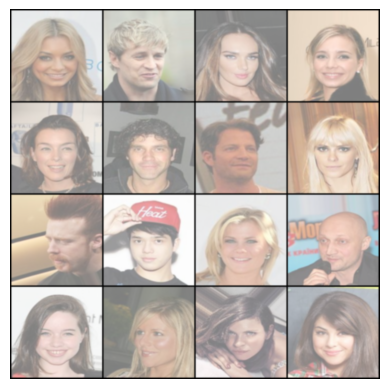

In [7]:
#Visualizing some reconstructions
batch, _ = next(iter(celeba_loader))
show(batch[0:16], renorm = True, nrow=4)

In [8]:
# Custom loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Initialize VAE model
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train the VAE
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_loss=np.inf
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    cpt=0
    for batch_idx, data in enumerate(celeba_loader):
        img, _ = data
        img = img.float().to(device)
        recon_img, mu, logvar = model(img)
        loss = vae_loss(recon_img, img, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cpt+=1

        if batch_idx % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(celeba_loader), total_loss/cpt))
    print('Epoch [{}/{}], Total Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(celeba_loader)))
    if total_loss<best_loss:
        best_loss=total_loss
        torch.save(model.state_dict(), 'celeba_vae.pth')




Epoch [1/50], Step [1/3166], Loss: 2187465.7500


KeyboardInterrupt: 

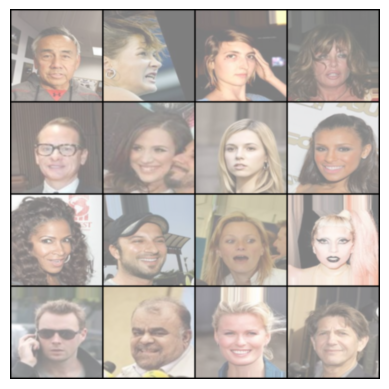

In [12]:
show(img[0:16].detach().cpu(), renorm = True, nrow=4)

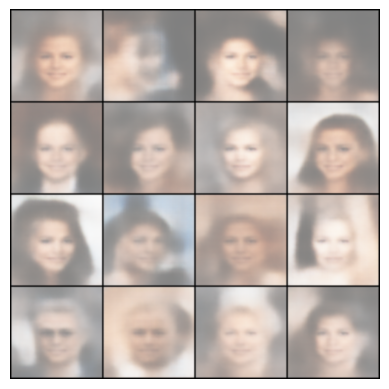

In [13]:
show(recon_img[0:16].detach().cpu(), renorm = True, nrow=4)